# Do the in- and out-strength histograms contain new information?

During the lab session on February 27th, we calculated, plotted and discussed the in- and out-strength histograms of the word-association network, and one comparison we made was between the strength and degree histograms, i.e. between the weighted and un-weighted degree histograms. At the end of that lab, I hinted at trying to guess the in- and out-strength histograms using the information in the in- and out-degree histograms and the edge weight histogram.

As a quick recap, here is the code we used for the calculation and the histograms we plotted:

In [1]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import matplotlib.pyplot as plt

In [2]:
import networkx
graph = networkx.read_edgelist('../lab_03/word_association_graph_DSF.txt', 
                               create_using=networkx.DiGraph(), 
                               nodetype=str, data=[('weight', float),])

In [3]:
in_degrees = {}
for node in graph.nodes():
    in_degrees[node] = 0
for source, target, attrs in graph.edges(data=True):
    in_degrees[target] += 1

In [4]:
out_degrees = {}
for node in graph.nodes():
    out_degrees[node] = 0
for source, target, attrs in graph.edges(data=True):
    out_degrees[source] += 1

In [5]:
in_strengths = {}
for node in graph.nodes():
    in_strengths[node] = 0
for source, target, attrs in graph.edges(data=True):
    in_strengths[target] += attrs['weight']

In [6]:
out_strengths = {}
for node in graph.nodes():
    out_strengths[node] = 0
for source, target, attrs in graph.edges(data=True):
    out_strengths[source] += attrs['weight']

Focusing on out-degree and out-strength, the plots we got:

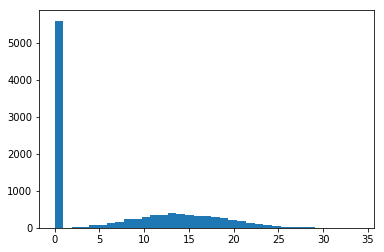

In [7]:
_ = plt.hist(out_degrees.values(), bins=35)

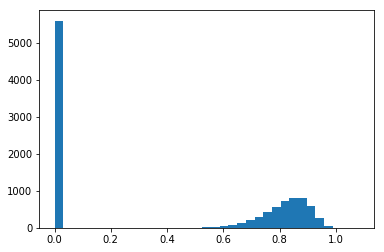

In [8]:
_ = plt.hist(out_strengths.values(), bins=35)

## Comparing the plots

We mentioned that some aspects are exactly the same: in particular, the spike at zero appears in both, and we also mentioned that this is not an accident: this spike is due to nodes that have no outgoing edges (most likely due to not being used as prompt-words when the data was collected), and if a node has no outgoing edges, it will have an out-strength of zero as well.

Other aspects of the histogram are only similar, without matching exactly: if we squint a little, we might consider the right-hand, smooth part of the histogram (i.e. everything apart from the spike at zero) as somewhat similar: we might consider these to be the same curve, just pushed around somewhat.

## What parts contain new information?

Obviously, the spike at zero contains no new information: we can guess that this part of the out-strenght distribution is going to look like that just by looking at the out-degree histogram. This might hint at the possibility that the rest of the out-strength histogram might be less surprising as well.

Studying this will be a bit problematic: it is somewhat difficult to characterise what we consider "information" as opposed to "data": it is easy to describe how much data we have in the plot, but much harder to quantify how much information that tells us. To formalize this somewhat, we can pose the following question:

Assuming that we know the out-degree and edge weight histograms, can we guess the out-strength histogram? What would be our best guess be?

(note: at this point it might be a good idea to take a five minute break and try to come up with ideas on your own: how would you approach making such a guess?)

As a reference: the edge weight histogram:

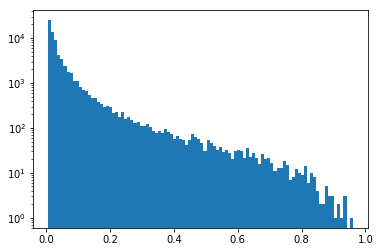

In [9]:
edge_weights = [attrs['weight'] for source, target, attrs in graph.edges(data=True)]
_ = plt.hist(edge_weights, bins=100, log=True)

Note also that the smallest and largest value is:

In [10]:
min(edge_weights), max(edge_weights)

(0.007, 0.96)

This reinforces our argument above that the spike at zero in the out-strength histogram is due to zero out-degree nodes, since the only way some other node (which has a non-zero out-degree) might end up in that spike is its outgoing edges have a weight of zero. As we can see, this is not the case.

Also, this range of edge weighs is completely in-line with what we mentioned before about how these edge weights are calculated: counting the number of answers and then calculating frequencies from them will lead to edge weights between 0 and 1.

# How to guess?

A suggestion for generating ideas: look at the code we use to calculate the out-degree and the out-strength histograms -- how would you modify the out-strength calculation to avoid actually using the out-strengths? (This "without actually using the out-strengths" part might sound very strange, but it will clear shortly.)

The two loops:

In [11]:
out_degrees = {}
for node in graph.nodes():
    out_degrees[node] = 0
for source, target, attrs in graph.edges(data=True):
    out_degrees[source] += 1

In [12]:
out_strengths = {}
for node in graph.nodes():
    out_strengths[node] = 0
for source, target, attrs in graph.edges(data=True):
    out_strengths[source] += attrs['weight']

The only essential difference between the two is replacing "+= 1" with "+= attrs['weight']". When trying to come up with our guess or estimate, this part is what we need to change -- what can we put here?

Obviously, whatever we put in, it needs to come from the edge weight histogram. But, using attrs['weight'] would be cheating, since in that case we are using the exact edge weights, and not just the histogram. What could we use from the histogram instead?

One possibility, is to calculate something from the histogram and put that here. What can we calculate from the histogram? Well, one option is to calculate a single number. If we restrict ourselves to that, it is quite obvious what number we can use: the average edge weight. This guess will look like this:

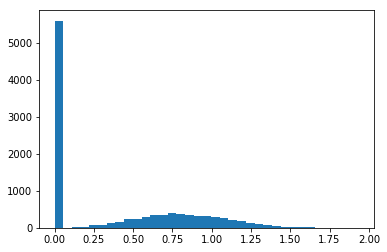

In [13]:
average_edge_weight = sum(edge_weights) / len(edge_weights)
out_strengths_guess_avg = {}
for node in graph.nodes():
    out_strengths_guess_avg[node] = 0
for source, target in graph.edges():
    out_strengths_guess_avg[source] += average_edge_weight

_ = plt.hist(out_strengths_guess_avg.values(), bins=35)

Comparing the shape of this plot to the previous ones, we might notice that it looks remarkably like the out-degree histogram -- and of course it looks exactly the same, since all we are doing is multiplying every out-degree value by this average edge weight. This means that all we end up with, is the exactly same plot, with the horizontal axis (which shows the values, with the vertical axis being the number of nodes in each bin) rescaled.

This doesn't seem like a good guess: the result we got doesn't show new information. Lets try making a better one!

How can we improve our guess? One obvious route is to try to use more of the edge weight histogram: in the previous, we distilled it down to only one number. What if we are more cautious, and try to use more information from that histogram?

One option to use more than one number would be to calculate additional statistical quantities: for example, in addition to the average, we might try calculating the mode, variance or standard deviation, or higher-order moments, like skewness, kurtosis, etc. Alternatively, we could try using a theoretical curve to estimate the edge weight histogram: if we can find a function that fits it well, we can use the fitting parameters to reproduce the histogram, and then use this model to generate new values to use in our loop that estimates the out-strengths.

This approach sounds like it could be more accurate (since it uses more data, more information from the edge weight histogram), but it also sounds like a lot of work, and quite complicated, having to come up with some function that fits the edge weight histogram, etc. Since our aim is to use more data from the edge weight histogram, we might jump ahead a bit: assuming that we did this "fit a function, use that" approach, if we are not happy with the results, our next step might be to "fit a better function", where "better" would mean "something that fits better, with less difference". Considering the general maxim that "more parameters will lead to a better fit" and that our immedate aim is to use more data/more information (i.e. more numbers) from the edge weight histogram, we can jump ahead and ask: instead of doing all these fits to come up with a model of the edge weight histogram, couldn't we simply use the edge weight histogram itself as its own model?

And yes, we can do that: simply use the histogram and pick values from that. We can do something like this:

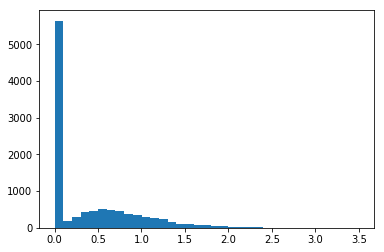

In [14]:
import random

out_strengths_randomized = {}
for node in graph.nodes():
    out_strengths_randomized[node] = 0
for source, target in graph.edges():
    out_strengths_randomized[source] += random.choice(edge_weights)

_ = plt.hist(out_strengths_randomized.values(), bins=35)

This looks much more interesting: it shows something different from both the out-degree and the actual out-strength histogram. It seems like we are actually getting somewhere. However, first, a digression:

What are we actually doing?

As we phrased it above, we are "trying to estimate out-strength without using the out-strengths", however wierd that sounds. Hopefully the two examples above, calculating out_strengths_randomized and out_strengths_guess_avg show the general idea. But there is another way to look at this task. These code-snippets above focus on the code that calculates these quantities, and this is a good way to think about these options. But we can rephrase these codes and our task as well. Consider that the general structure of these calculations are the same. We are doing essentially the same loops, just the "+= ..." part changes. Thus, we could consider these as calculating the out-strength for a wierd network.

For out_strengths_guess_avg, we are essentially calculating the out-strength for a network where all the edge weights are average_edge_weight, while for out_strengths_randomized, we are calculating the out-strength for a network where the edge weights are randomly chosen from a list.

If we formulate the problem like this, we are not actually working on to generating or guessing the out-strength histogram. Instead, we are actually working on generating a model of our network!

If we rewrite our previous codes in this manner, we might generate modified copies of the network like this:

In [15]:
graph_avg_edgeweights = graph.copy()
for source, target in graph_avg_edgeweights.edges():
    graph_avg_edgeweights[source][target]['weight'] = average_edge_weight

graph_randomized = graph.copy()
for source, target in graph_randomized.edges():
    graph_randomized[source][target]['weight'] = random.choice(edge_weights)


One big advantage of this approach is that it allows using the same code for calculating the out-strengths. Of course, this doesn't look like a big win, since we copy that part of the code each time to run it, but it will be more obvious if we turn it into a reusable function:

In [16]:
def out_strengths(network):
    out_strengths = {}
    for node in network.nodes():
        out_strengths[node] = 0
    for source, target, attrs in network.edges(data=True):
        out_strengths[source] += attrs['weight']
    return out_strengths

Once we are turning things into functions, we might want to do the same with the generation methods, as well:

In [17]:
def graph_avg_edgeweights(network):
    edge_weights = [attrs['weight'] for source, target, attrs in network.edges(data=True)]
    average_edge_weight = sum(edge_weights) / len(edge_weights)

    graph_avg_edgeweights = network.copy()
    for source, target in graph_avg_edgeweights.edges():
        graph_avg_edgeweights[source][target]['weight'] = average_edge_weight
    return graph_avg_edgeweights

def randomize_edgeweights(network):
    edge_weights = [attrs['weight'] for source, target, attrs in network.edges(data=True)]
    graph_randomized = network.copy()
    for source, target in graph_randomized.edges():
        graph_randomized[source][target]['weight'] = random.choice(edge_weights)
    return graph_randomized

These functions allow making the same plots as above as simply as:

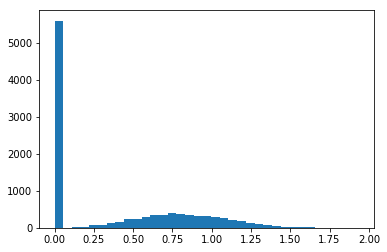

In [18]:
_ = plt.hist(out_strengths(graph_avg_edgeweights(graph)).values(), bins=35)

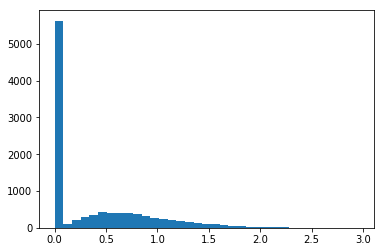

In [19]:
_ = plt.hist(out_strengths(randomize_edgeweights(graph)).values(), bins=35)

Using these functions, we can reconsider what we are actually doing:
    
We are trying to come up with an estimate for the out-strength histogram, using only the out-degree histogram and the edge weight histogram. This essentially means that we are going to use the nodes and edges, and which edge is connected to which node, but we are not allowed to use the information of which edge weight is on which edge.

Although not a requirement in the original formulation of the task (since then we weren't even talking about generating variants of the network itself), we might question how the edge weight histogram of our networks look like. Since were are allowed to use this histogram, to get an accurate estimate, we might consider that preserving this histogram would be a good idea: i.e. our generated networks should have the same edge weight histogram as the original one.

We can easily plot this histogram for the networks, creating a function to extract a list of edges will make this even easier:

In [20]:
def edge_weights(network):
    return [attrs['weight'] for source, target, attrs in network.edges(data=True)]

The edge weight histogram for our variant that uses the average edge weights is not really surprising:

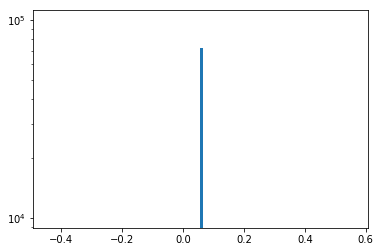

In [21]:
_ = plt.hist(edge_weights(graph_avg_edgeweights(graph)), bins=100, log=True)

For this network, we are replacing all the edge weights with the average value, so it is not surprising that the edge weight histogram shows a single peak at this average value.

Looking at the randomized variant:

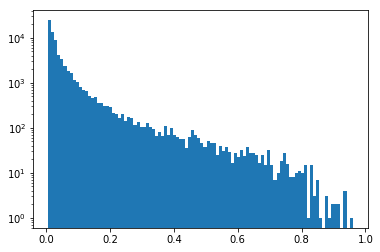

In [22]:
_ = plt.hist(edge_weights(randomize_edgeweights(graph)), bins=100, log=True)

This looks quite good: it looks basically the same as the original one. But is it actually the original?

Comparing the two on the same plot:

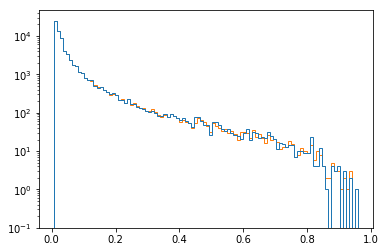

In [23]:
_ = plt.hist([edge_weights(randomize_edgeweights(graph)), edge_weights(graph)],
             bins=100, log=True, histtype='step')

We can see some difference. Is that a problem? In the original formulation of the task, no (since we only need to estimate the out-strength histogram, and generating a new network is not even considered). However, we might want to ensure that the edge weight histogram stays the same: after all, to generate the best possible estimated out-strength histogram, ensuring that this detail is not differ seems like a good idea.

Why do these two edge weight histograms differ? After all, every edge weight we use is an actual edge weight, since it is chosen at random from the list of edge weights. Essentially we are just moving the edge weights around.

However, there is an aspect here that, strictly speaking, we already faced before: since we have a list of edge weights we pick randomly from using random.choice(), some weights will be chosen multiple times, while others might not be chosen at all. This is the same issue we had with picking the endpoints for the shortcuts in the "ring & shortcuts" network, were the even distribution of the shortcuts turned out to be an issue.

To ensure that we reproduce the edge weight histogram exactly, we need to do the same thing here, as we did with the "ring & shortcuts" network: ensure that we pick each edge weight only once. To do that, a simple solution is to remove each edge weight from the list as we pick them. Alternatively, we can accomplish this by iterating over the edges and the edge weights (in random order!). This will look somewhat like this:

In [24]:
def randomize_edgeweights2(network):
    edge_weights = [attrs['weight'] for source, target, attrs in network.edges(data=True)]
    random.shuffle(edge_weights) # randomizes order, in-place
    graph_randomized = network.copy()
    for (source, target), edge_weight in zip(graph_randomized.edges(), edge_weights):
        graph_randomized[source][target]['weight'] = edge_weight
    return graph_randomized

This code uses the zip() function to iterate over two objects. This will return items, which in this case, are a tuple (of the edge endpoints) and an edge weight. Note that we can "unpack" all of this into the loop variables.

Plotting the edge weight histogram after this randomization, we get the following:

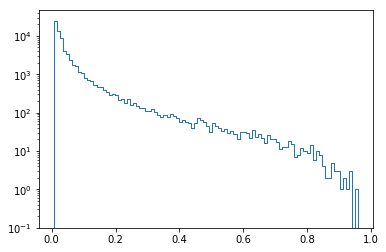

In [25]:
_ = plt.hist([edge_weights(randomize_edgeweights2(graph)), edge_weights(graph)],
             bins=100, log=True, histtype='step')

The fact that only one line is visible shows that the two histograms match.

(Note also how easy it is to experiment with plots like this due to using functions to structure our code.)

Coming back to the original task, we can note what randomize_edgeweights2() ends up doing: it randomizes the placement of the edge weights, thereby breaking the connection between the edge weight and which edge it is on. We can imagine this the following way: assume that the edge weights are written on post-it notes that are stuck to the edges. We remove these post-it notes, which means that we have a network with only the nodes and edges, and a big pile of post-it notes. Then, we shuffle the post-it notes and go around and stick them to the edges again. This will mean that we preserve the degree histogram as well as the edge weight histogram, but we destroy the connection between individual edges and edge weights.

Note that randomizing a network like this is a very good method for data analysis: we can study all sorts of correlations and their effect on the network and its behaviour, as long as we can identify a randomization procedure that destroys that correlation. This is often a much better approach than the alternative of trying to come up with a network model (like Erdős-Rényi, Barabási-Albert, Watts-Strogatz or similar models) that is similar to our network: if we use such a model, the generated reference network and our original network will differ in many aspects. Doing the randomization instead, we generate a reference network that only differs in the property that we randomized, and is the same in other aspects.

Lets check what we get for the randomized out-strength distribution using our randomize_edgeweights2() method, and compare it to the actual out-strength distribution:

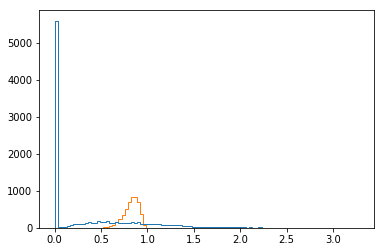

In [26]:
_ = plt.hist([list(out_strengths(randomize_edgeweights2(graph)).values()),
              list(out_strengths(graph).values()),
             ], bins=100, histtype='step')

As we can see, the two differ, which shows that there is significant correlation between the edge weights and node degrees. This is caused by normalization procedure that calculates the edge weights as frequencies from the answer counts. Our randomized out-strength histogram is much flatter, spreading to values much larger than 1.

We can also take a look at the in-strength histogram, as well. Using the same functions as before, we only need to write a function for calculating the in-strength histogram and we can re-use the randomization functions:

In [27]:
def in_strengths(network):
    in_strengths = {}
    for node in network.nodes():
        in_strengths[node] = 0
    for source, target, attrs in network.edges(data=True):
        in_strengths[target] += attrs['weight']
    return in_strengths

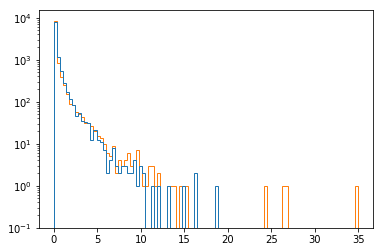

In [28]:
_ = plt.hist([list(in_strengths(randomize_edgeweights2(graph)).values()),
              list(in_strengths(graph).values()),
             ], bins=100, histtype='step', log=True)

We have mentioned above that the actual and the randomized out-strength histograms differ. Do the in-strength histograms differ? Strictly speaking yes, because we can see both colors on the plot, i.e. they don't match the same way the edge weight histograms matched (once we took care not to re-use edge weights during the randomization). But are they different histograms? 

This question is easy to answer for the out-strength, since the histograms are obviously different. For the in-strength histogram, this is a much trickier question since the shape of the two histograms are so similar, and we expect some random noise from the randomized in-strength histogram. How could we tell whether the small differences we see are significant or not?